In [1]:
# Import needed libraries
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, validation_curve
from sklearn.metrics import (explained_variance_score, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             median_absolute_error, r2_score)

# ML Libraries
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate

# Viz Libraries
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_pickle('data/listings_cleaned_processed_stepForward.pkl')

X = df.drop(columns='price_log', axis=1)
y = df.price_log

df.head()

,host_listings_count,accommodates,bathrooms,bedrooms,cleaning_fee,extra_people,availability_30,review_scores_rating,room_type_Private room,room_type_Shared room,price_log
0,1.0,10,7.0,5.0,200.0,0.0,27,96.0,False,False,8.006368
1,1.0,2,1.0,1.0,55.0,0.0,29,93.0,True,False,3.912023
2,1.0,2,1.0,1.0,55.0,10.0,18,100.0,True,False,4.007333
3,1.0,6,1.0,1.0,35.0,0.0,3,100.0,False,False,5.010635
4,1.0,1,1.0,1.0,5.0,10.0,0,93.0,True,False,3.401197


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1234)

In [3]:
classifiers = {
    'LinearReg': LinearRegression(fit_intercept=True, n_jobs=-1),
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=123, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=123),
    'BayesianRidge': BayesianRidge()
}

In [4]:
def model_eval(model, features):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    try:
        feature_importance = pd.Series(model.feature_importances_, features)
    except:
        feature_importance = pd.Series(model.coef_, features)
    finally:
        top = feature_importance[list(
            feature_importance.abs().nlargest(20).index)].sort_values(
                ascending=True)
        top.plot(kind='barh', title='Feature Importance (Top 20)', ax=ax1)

    viz = LearningCurve(model, scoring='neg_mean_squared_error', cv=10, ax=ax2)
    viz.fit(X_train, y_train)
    viz.finalize()

    viz = ResidualsPlot(model, ax=ax3)
    viz.fit(X_train, y_train)
    viz.finalize()

    viz = PredictionError(model, ax=ax4)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
    plt.tight_layout()
    plt.show()


results_overall = []


def overall_eval(results):
    display(Markdown('# Estimator Comparison'))
    columns = [
        'Estimator', 'Mean Standard Error', 'R-Squared', 'Explained Variance',
        'Mean Absolute Error', 'Model Runtime'
    ]
    res = pd.DataFrame(results, columns=columns)
    col = [
        'Mean Standard Error', 'R-Squared', 'Explained Variance',
        'Mean Absolute Error', 'Model Runtime'
    ]

    for c in col:
        f, axes = plt.subplots(figsize=(11, 5))
        sns.barplot(x=res[c], y=res['Estimator'],
                    palette='GnBu_d').set_title(c, fontsize=20)
        plt.show()


def RegressionPipeline(X, y):

    results = []

    for name, clf in classifiers.items():
        start = time.time()
        model = clf
        model.fit(X, y)
        predict = model.predict(X)
        features = [x for x in X.columns]  # List of features

        # Calculate Scores
        mse, rsquare, evs, mae = mean_squared_error(y, predict), r2_score(
            y, predict), explained_variance_score(
                y, predict), mean_absolute_error(y, predict)

        # Print the output reports
        display(Markdown(f'# Results For {name} Model'))
        display(
            Markdown(
                '### Mean Standard Error (MSE) :<span style="color:red"> %.3g</span>'
                % (mse)))
        print(
            "R Squared: %.3g | Explained Variance Score: %.3g | Mean Absolute Error: %.3g"
            % (rsquare, evs, mae))

        model_eval(model, features)

        end = time.time()
        runtime = (end - start)
        print('Elapsed Runtime: %.3g seconds' % (runtime))

        display(Markdown(f'***'))

        results.append([name, mse, rsquare, evs, mae, runtime])
        results_overall.append([name, mse, rsquare, evs, mae, runtime])

    overall_eval(results)

# Model Evaluation

# Results For LinearReg Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.21</span>

R Squared: 0.667 | Explained Variance Score: 0.667 | Mean Absolute Error: 0.328


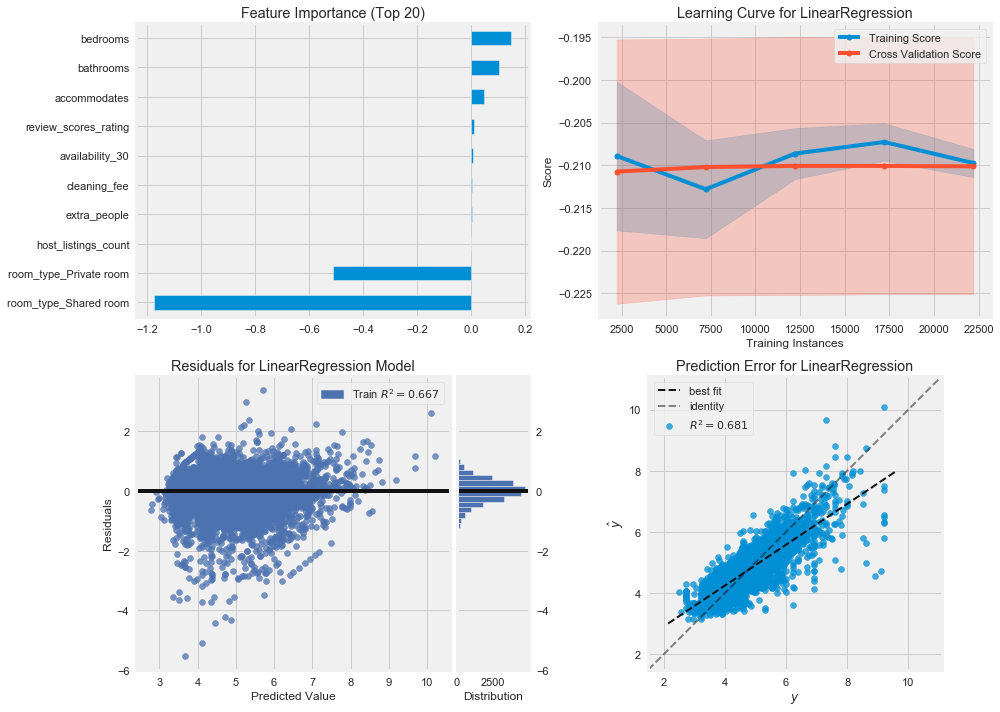

***

Elapsed Runtime: 2.58 seconds


# Results For RandomForest Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.199</span>

R Squared: 0.684 | Explained Variance Score: 0.684 | Mean Absolute Error: 0.325


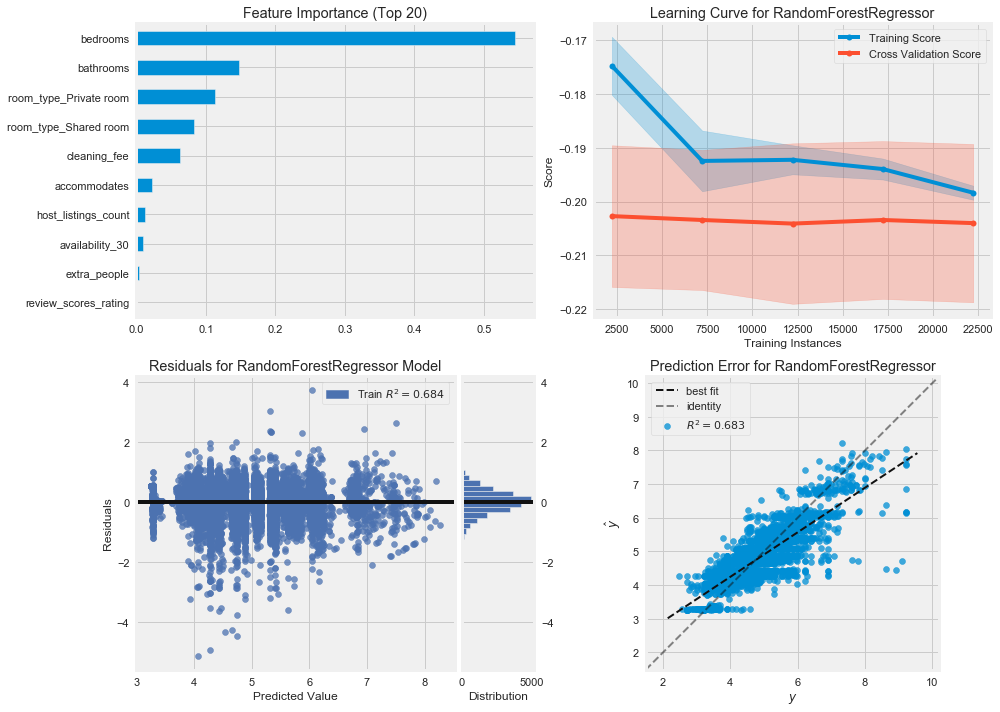

Elapsed Runtime: 27.5 seconds


***

# Results For GradientBoosting Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.165</span>

R Squared: 0.739 | Explained Variance Score: 0.739 | Mean Absolute Error: 0.295


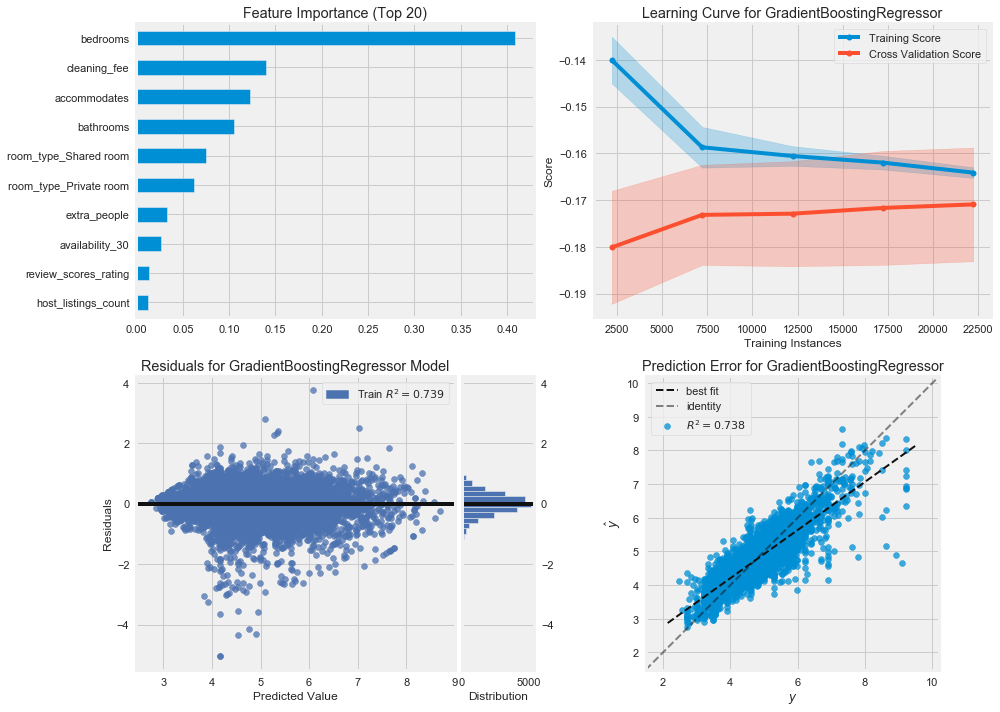

Elapsed Runtime: 21.1 seconds


***

# Results For BayesianRidge Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.21</span>

R Squared: 0.667 | Explained Variance Score: 0.667 | Mean Absolute Error: 0.328


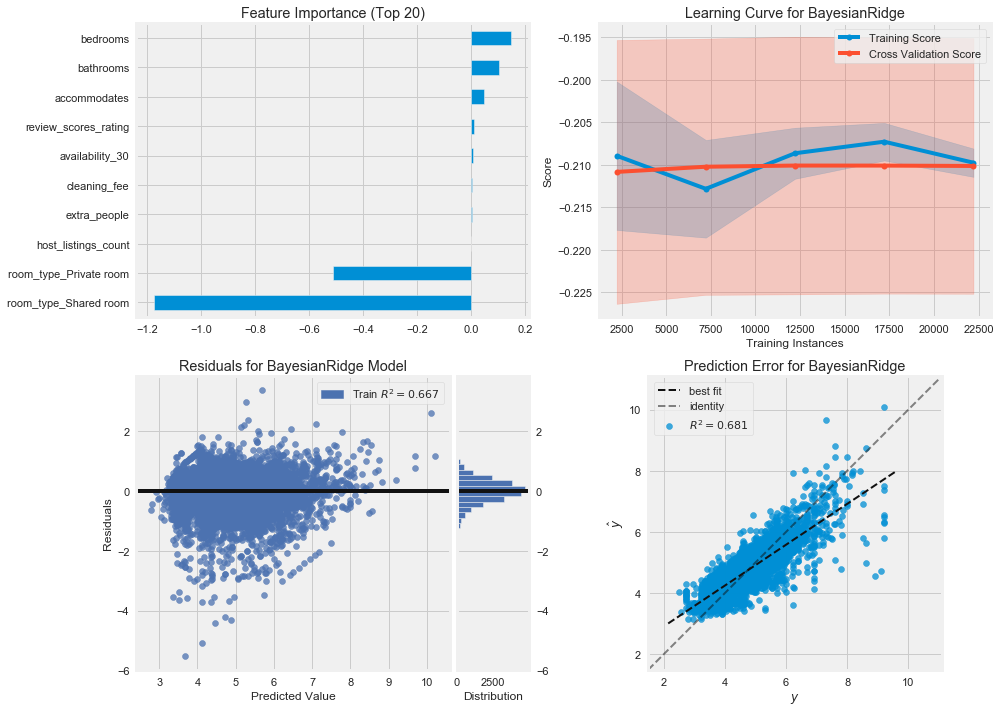

Elapsed Runtime: 2.31 seconds


***

# Estimator Comparison

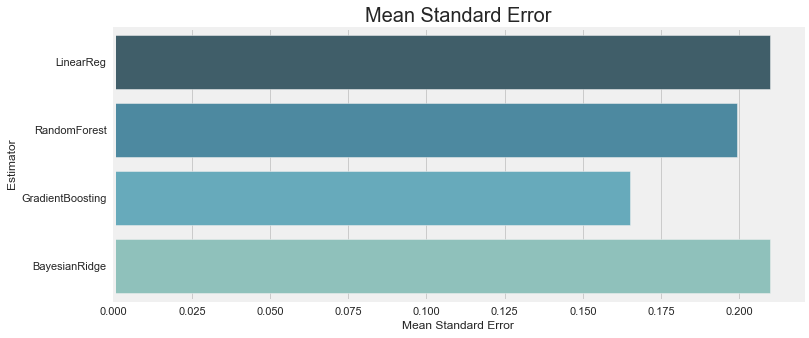

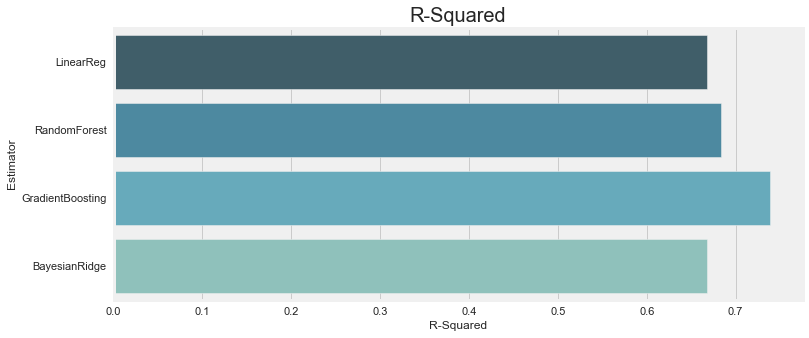

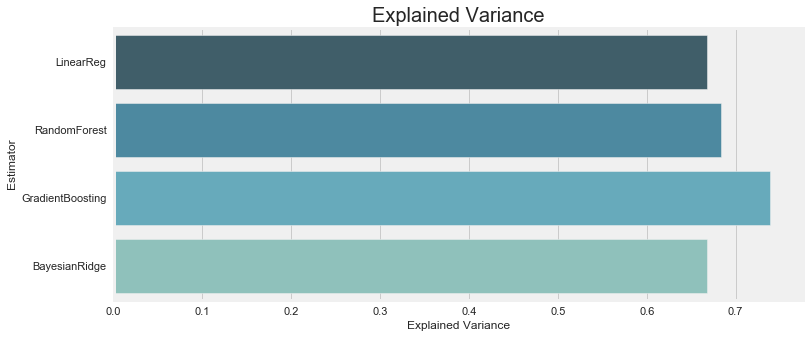

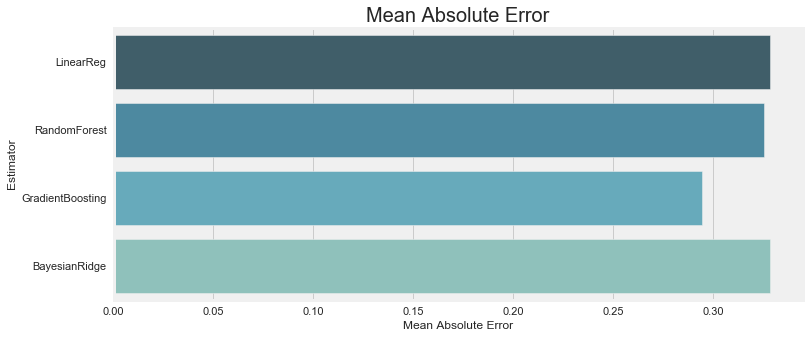

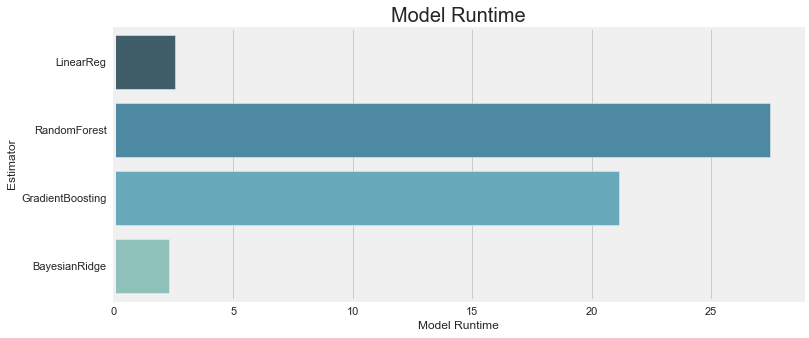

In [5]:
RegressionPipeline(X_train,y_train)

# Model Optimization

In [6]:
param_grid = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': np.arange(.1, 1, .1),
    'n_estimators': [50, 75, 100],
    'max_features': [None, 6, 8],
    'max_depth': [None, 5, 10]
}

# execute the grid search
model = GradientBoostingRegressor(random_state=123)
search = RandomizedSearchCV(model,
                            param_grid,
                            cv=5,
                            verbose=2,
                            n_jobs=-1,
                            scoring='r2',
                            n_iter=250)
search.fit(X_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 74.1min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 106.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...e=123, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=250, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber', 'quantile'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'n_estimators': [50, 75, 100], 'max_features': [None, 6, 8], 'max_depth': [None, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='r2', verbose=2)

In [7]:
search.best_params_ 

{'n_estimators': 100,
 'max_features': 6,
 'max_depth': 5,
 'loss': 'huber',
 'learning_rate': 0.2}

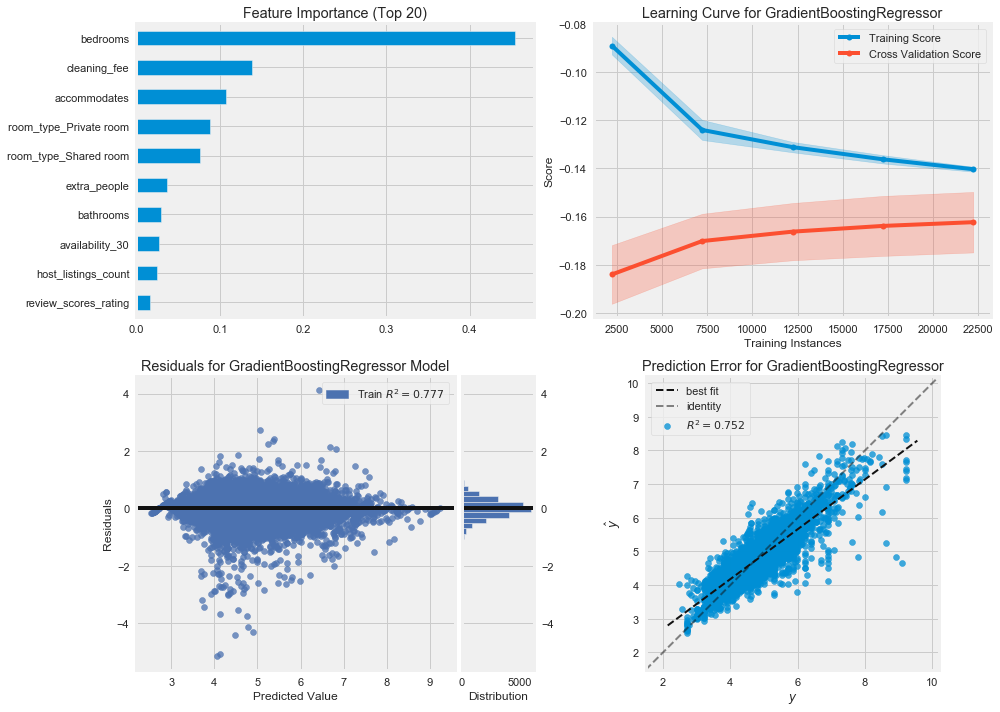

In [8]:
features = [x for x in X.columns]
model_eval(search.best_estimator_,features)